In [6]:
import normflows as nf
# Set up model



# Import required packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt

from tqdm import tqdm


# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)

In [7]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [8]:
# Define target distribution
target = nf.distributions.TwoMoons()

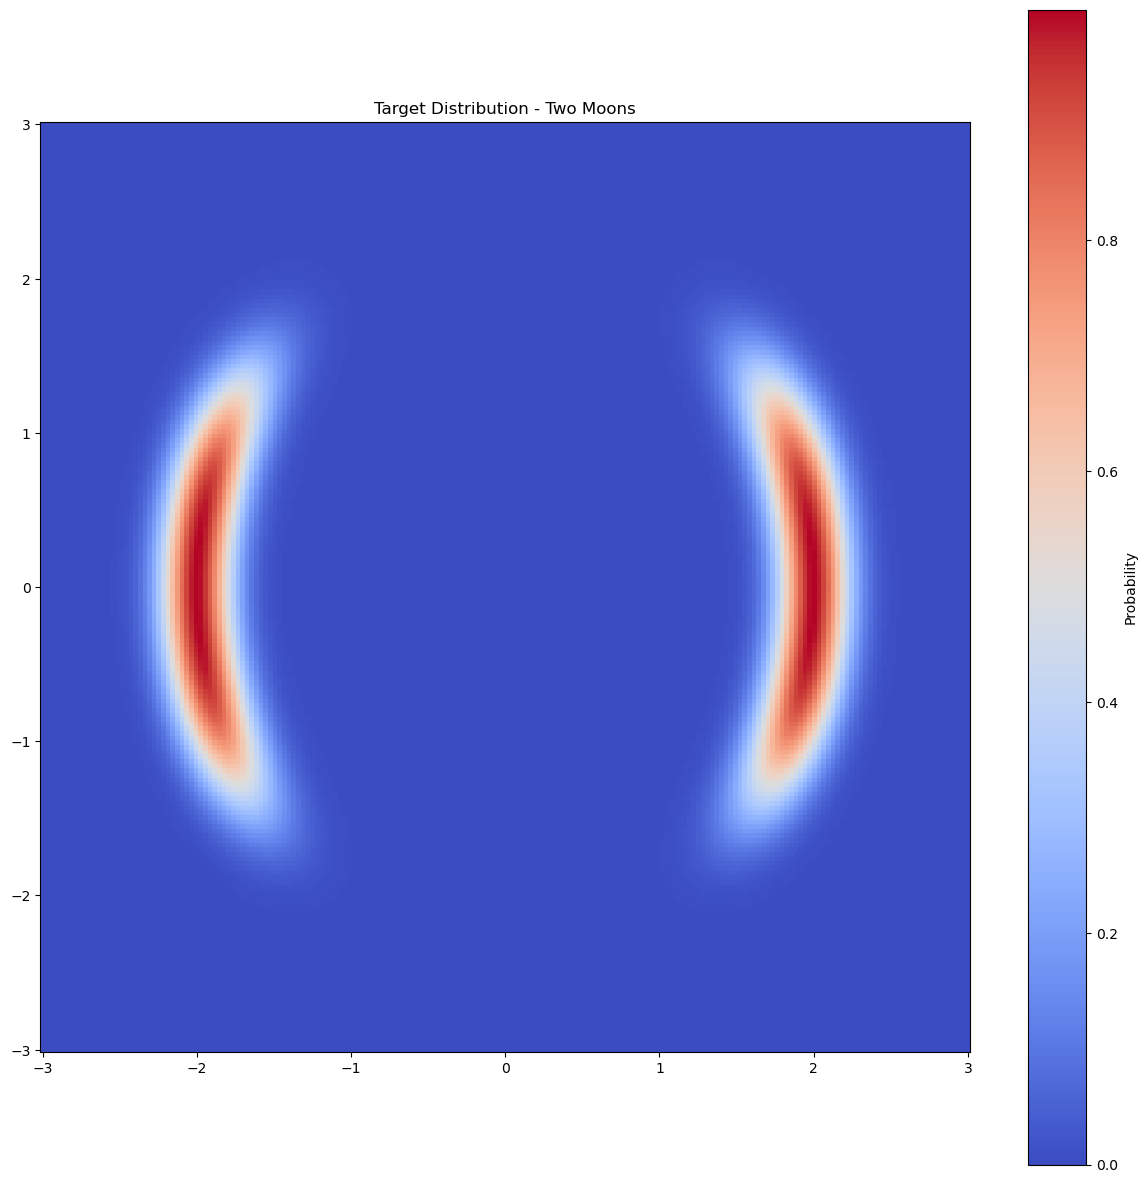

In [9]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

log_prob = target.log_prob(zz).to('cpu')  # Ensure it's on the CPU for numpy compatibility
prob = torch.exp(log_prob).view(grid_size, grid_size)  # Reshape to (grid_size, grid_size)
prob[torch.isnan(prob)] = 0  # Handle NaNs

# Plot the 2D probability distribution
plt.figure(figsize=(15, 15))
plt.pcolormesh(xx.numpy(), yy.numpy(), prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.colorbar(label="Probability")
plt.title("Target Distribution - Two Moons")
plt.show()

 12%|█▏        | 499/4000 [00:23<02:46, 21.06it/s]

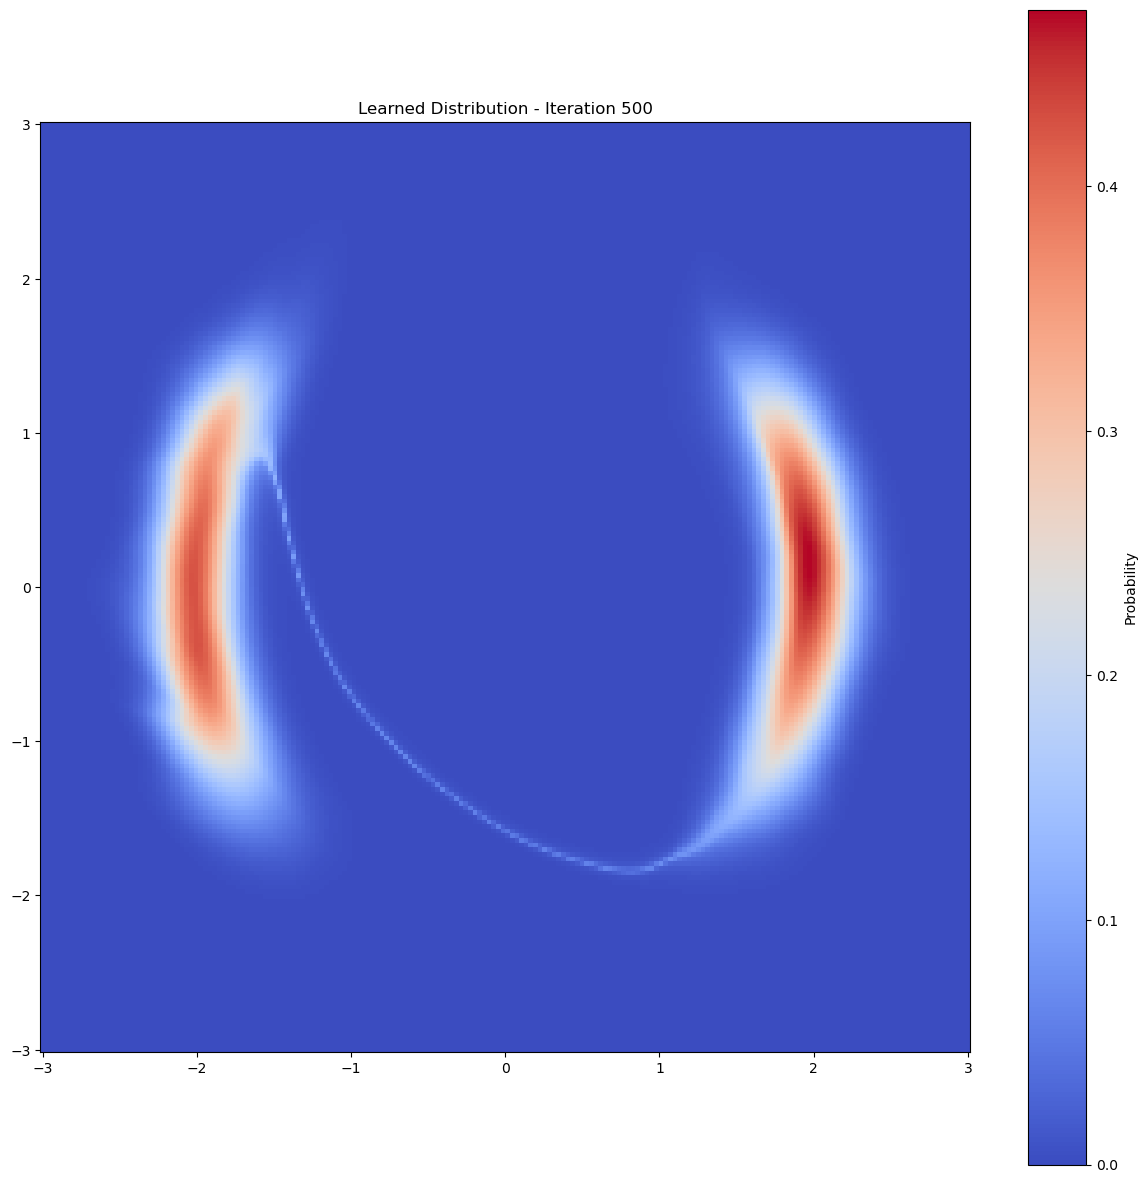

 25%|██▍       | 997/4000 [00:47<02:18, 21.69it/s]

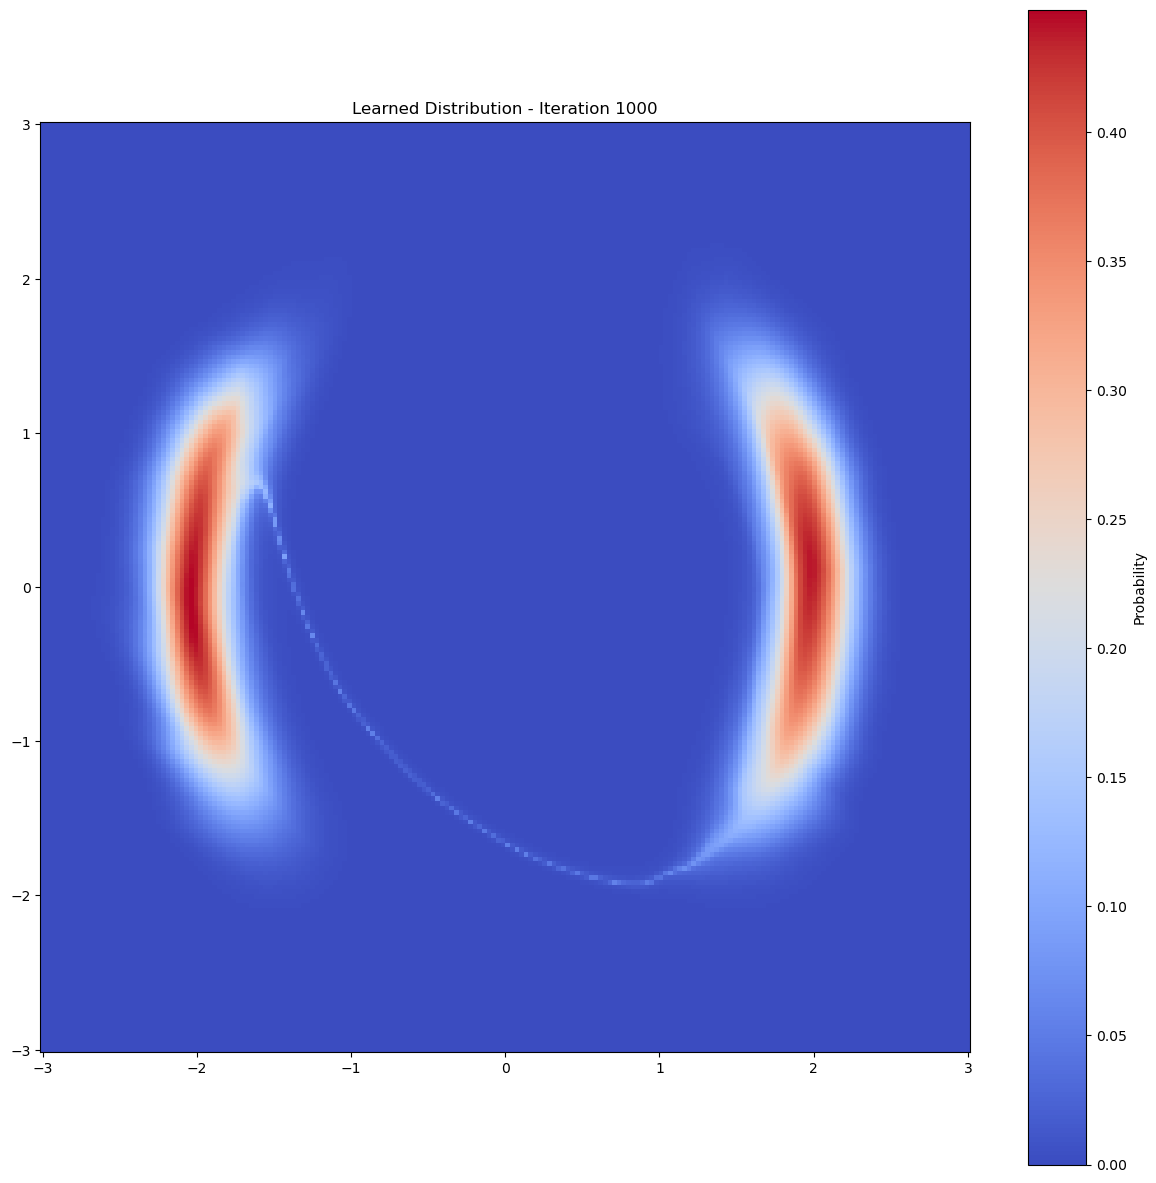

 37%|███▋      | 1499/4000 [01:16<02:32, 16.42it/s]

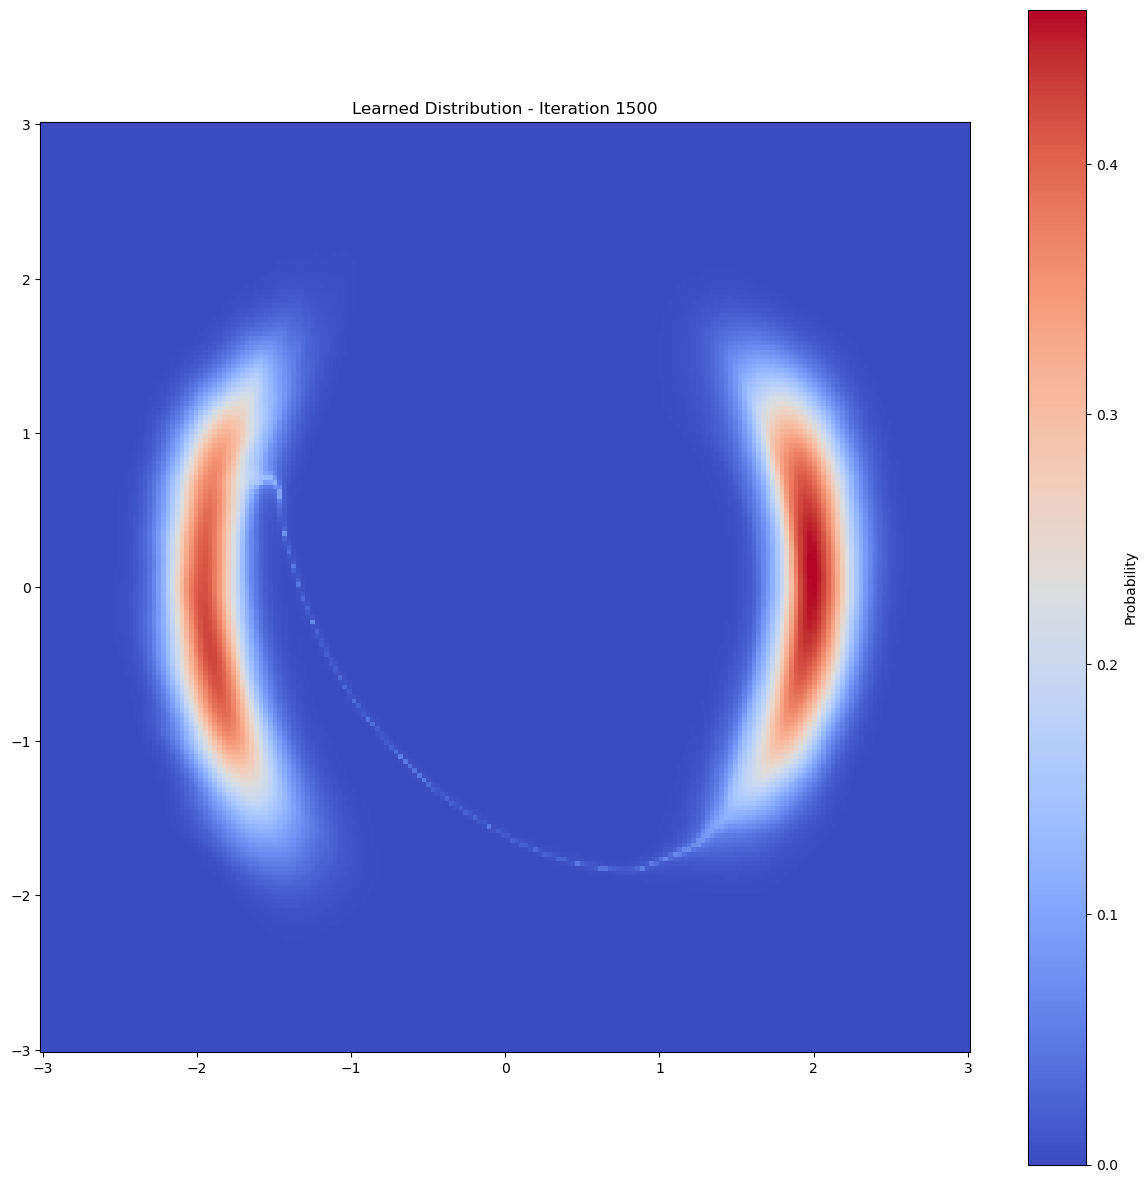

 50%|████▉     | 1998/4000 [01:44<01:52, 17.78it/s]

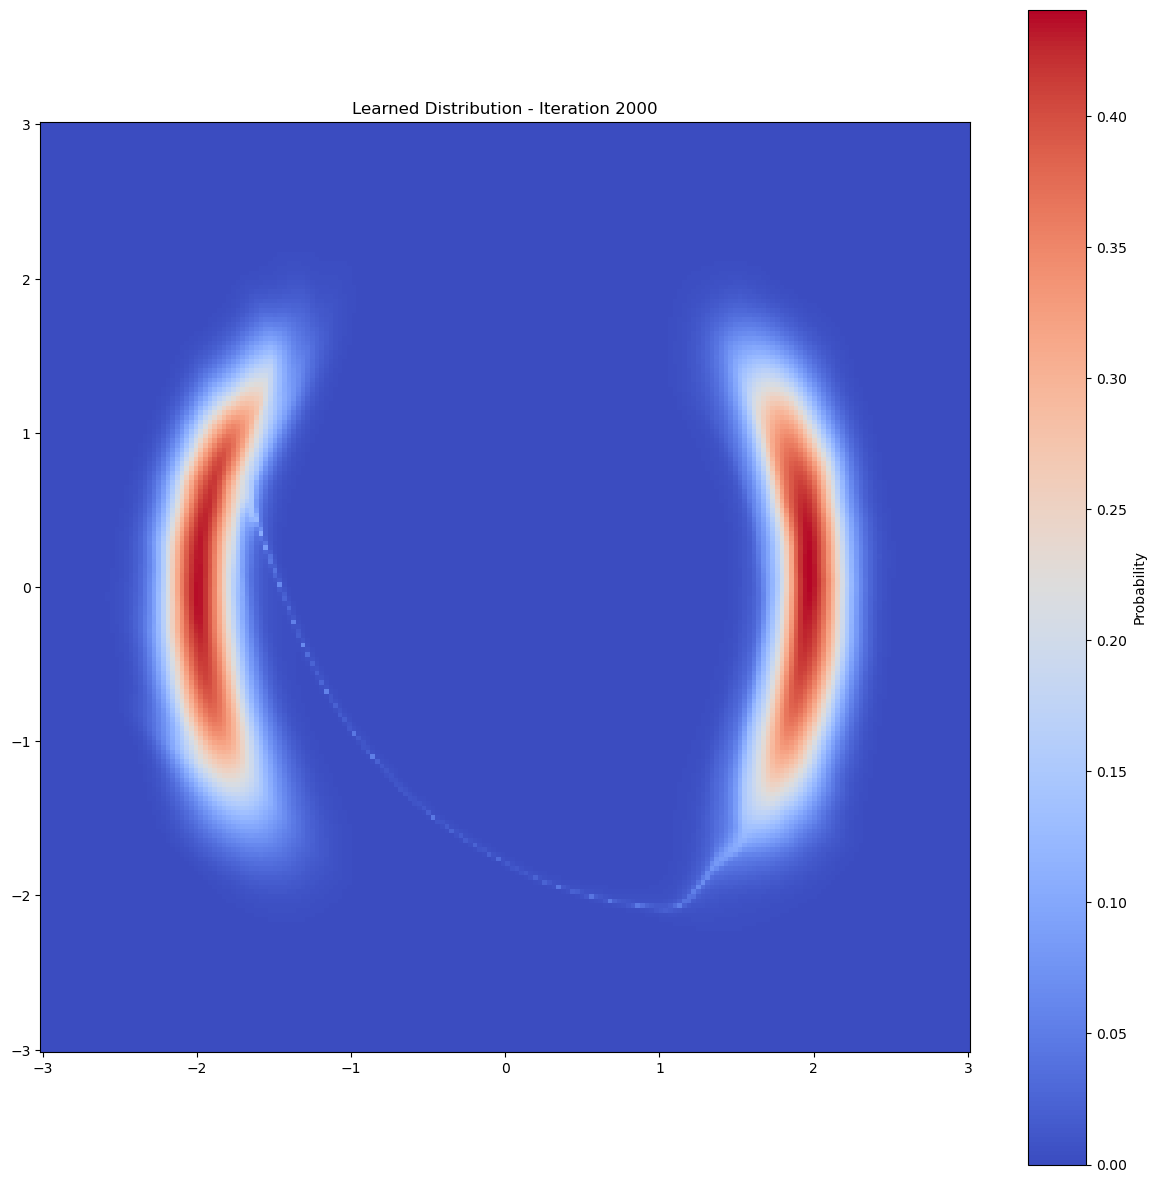

 62%|██████▏   | 2498/4000 [02:11<01:19, 18.87it/s]

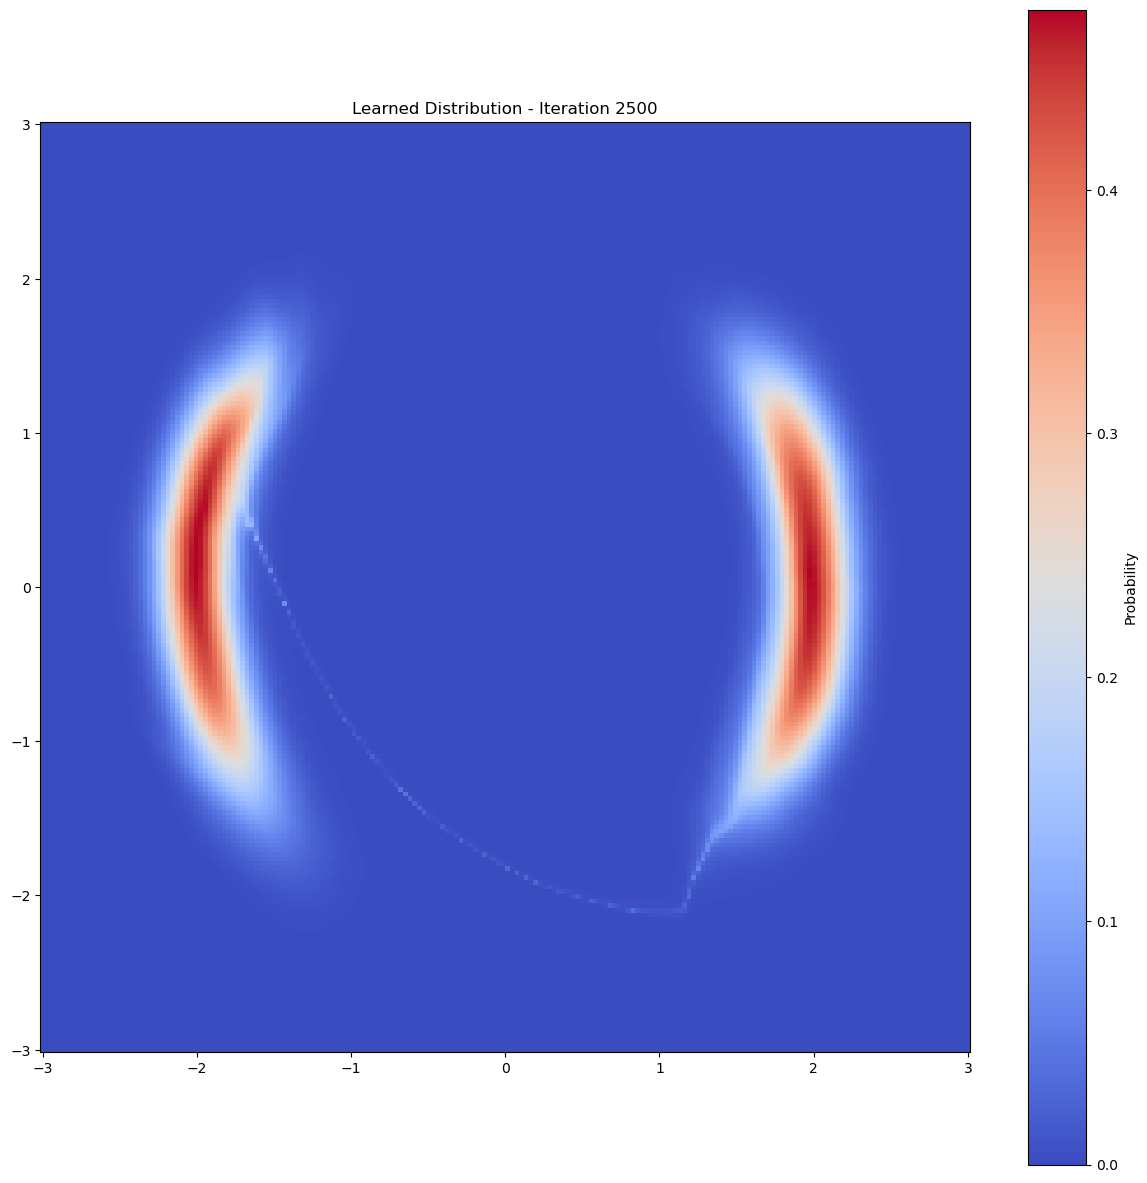

 75%|███████▍  | 2999/4000 [02:41<00:52, 18.95it/s]

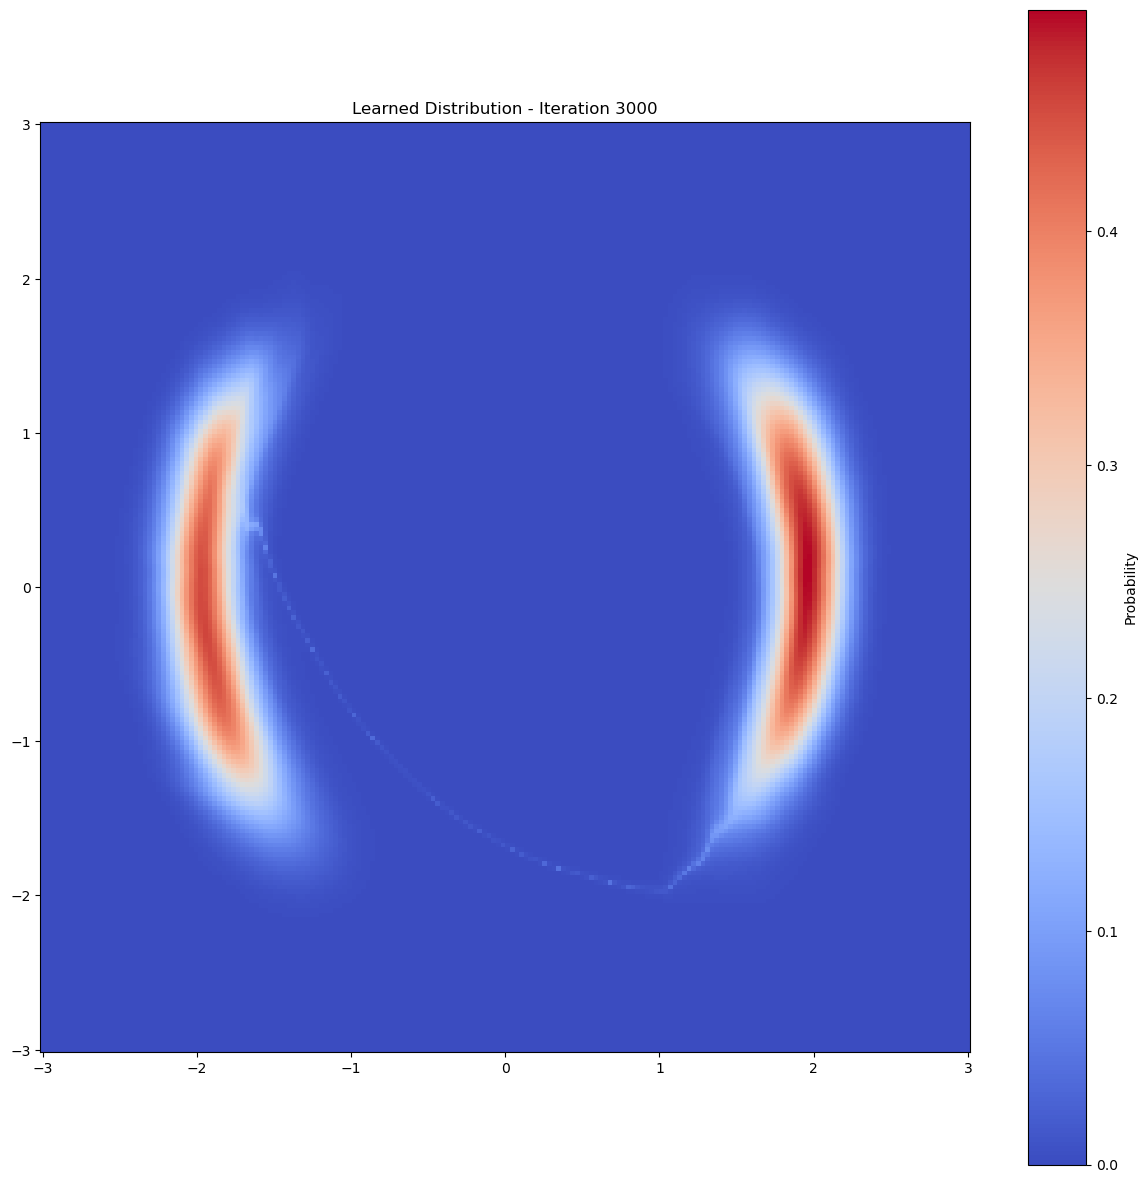

 87%|████████▋ | 3499/4000 [03:08<00:27, 18.03it/s]

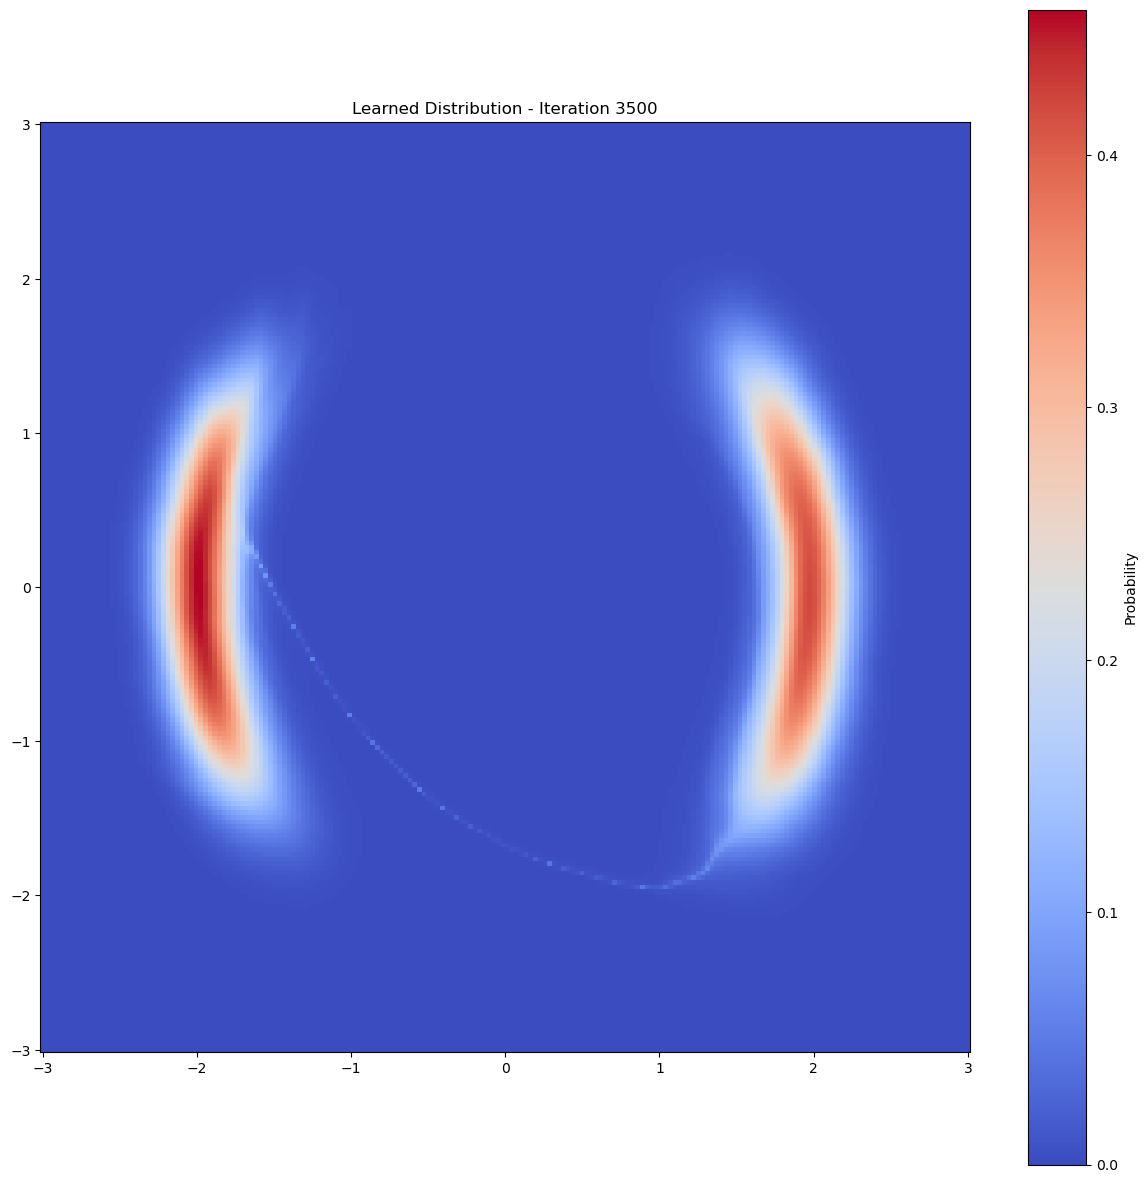

100%|█████████▉| 3998/4000 [03:36<00:00, 19.19it/s]

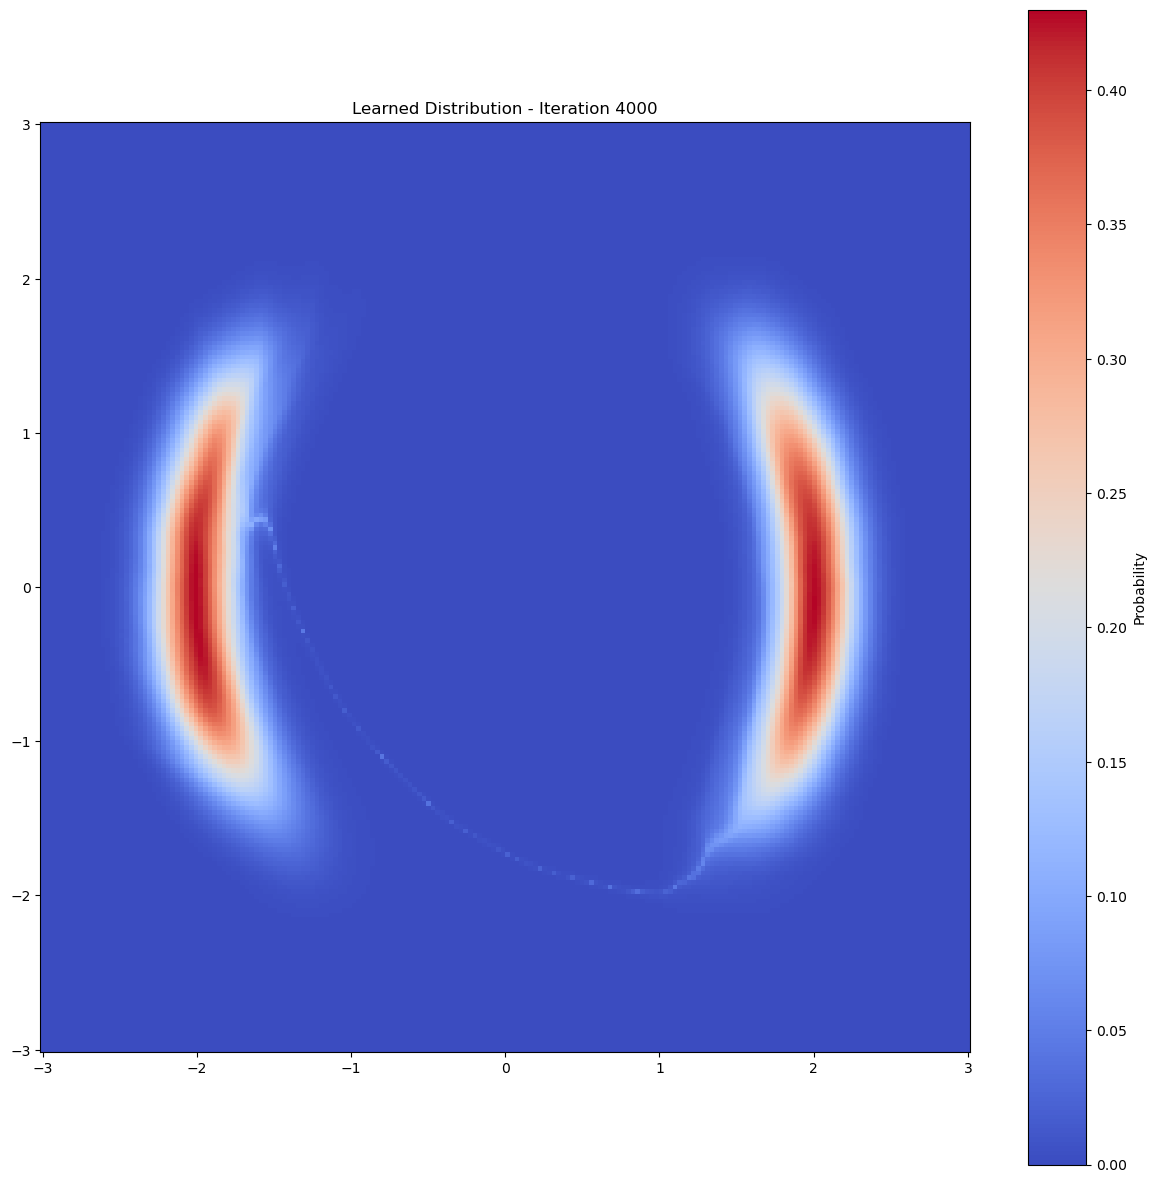

100%|██████████| 4000/4000 [03:37<00:00, 18.43it/s]


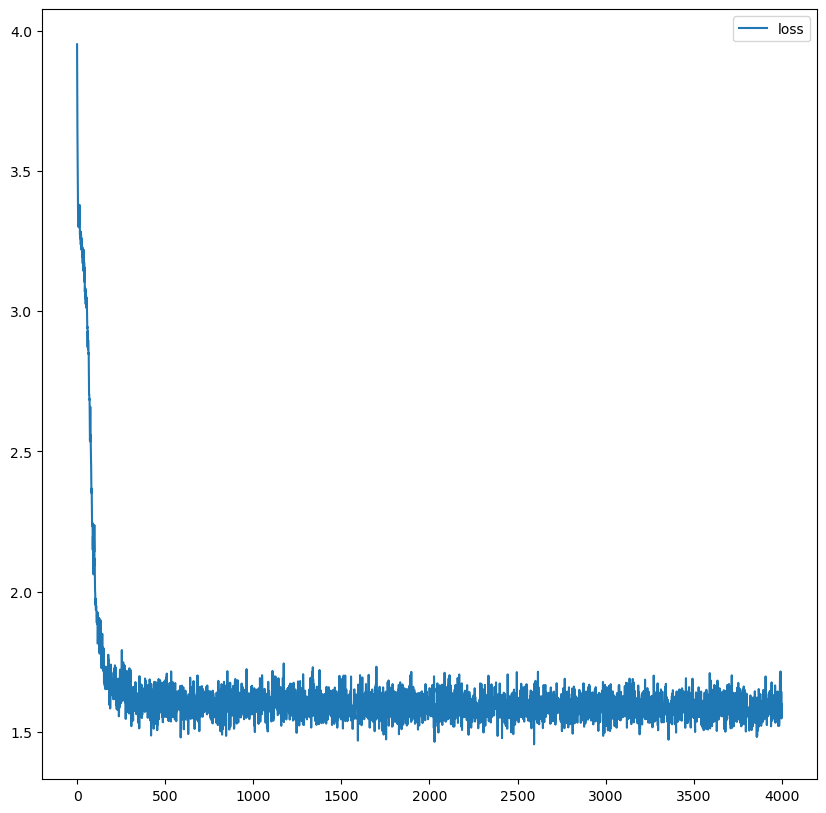

In [ ]:
# Train model
max_iter = 1000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x = target.sample(num_samples).to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
         model.eval()
         log_prob = model.log_prob(zz).to('cpu')  # Move log probabilities to CPU
         model.train()
    
    # Reshape `log_prob` and compute probabilities
         prob = torch.exp(log_prob).view(grid_size, grid_size)
         prob[torch.isnan(prob)] = 0  # Handle NaNs

    # Plot the 2D probability distribution
         plt.figure(figsize=(15, 15))
         plt.pcolormesh(xx.numpy(), yy.numpy(), prob.data.numpy(), cmap='coolwarm')
         plt.gca().set_aspect('equal', 'box')
         plt.colorbar(label="Probability")
         plt.title(f"Learned Distribution - Iteration {it + 1}")
         plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()s